In [36]:
import json
import re
import os
from pathlib import Path

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile
import torch
import torchvision.transforms.functional as TF
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.dpi'] = 300

In [5]:
import mushroom.utils as utils
from mushroom.registration import read_bigwarp_warp_field, register_adata, register_codex, warp_pts
from mushroom.dataloaders import incorporate_hi_res

In [43]:
run_dir = '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/'
out_dir = os.path.join(run_dir, 'registered')
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [7]:
out_dir

'/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered'

In [8]:
metadata = json.load(open(os.path.join(run_dir, 'slices_unregistered', 'metadata.json')))
metadata

{'downsample_scaler': 0.1,
 'phenocycler_pixels_per_micron': 1.9604911906033102,
 'order': ['HT397B1-S1H3A1U1',
  'HT397B1-S1H3A1U2',
  'HT397B1-S1H3A1U12',
  'HT397B1-S1H3A1U21',
  'HT397B1-S1H3A1U22',
  'HT397B1-S1H3A1U31']}

In [9]:
slice_to_sid = {f's{i}':sid for i, sid in enumerate(metadata['order'])}
sid_to_slice = {v:k for k, v in slice_to_sid.items()}
slice_to_sid

{'s0': 'HT397B1-S1H3A1U1',
 's1': 'HT397B1-S1H3A1U2',
 's2': 'HT397B1-S1H3A1U12',
 's3': 'HT397B1-S1H3A1U21',
 's4': 'HT397B1-S1H3A1U22',
 's5': 'HT397B1-S1H3A1U31'}

In [10]:
fps = sorted(utils.listfiles(os.path.join(run_dir, 'ddfs'),
                             regex=r'/s[0-9]+.*$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1_v2/ddfs/s1.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/ddfs/s2.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/ddfs/s3.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/ddfs/s4.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/ddfs/s5.tiff']

In [11]:
slice_to_ddf = {fp.split('/')[-1].split('.')[0]:read_bigwarp_warp_field(
    fp, metadata['downsample_scaler']) for fp in fps}
slice_to_ddf.keys()

dict_keys(['s1', 's2', 's3', 's4', 's5'])

## spatial transcriptomics

In [12]:
fps = [
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/HT397B1-S1H3A1U1',
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/HT397B1-S1H3A1U21',
]
sid_to_adata = {fp.split('/')[-1]:fp for fp in fps}

fps = {
    'HT397B1-S1H3A1U1':  '/data/spatial_transcriptomics/highres_images/breast/A1_HT397B1-S1H3A1U1.tif',
    'HT397B1-S1H3A1U21': '/data/spatial_transcriptomics/highres_images/breast/B1_HT397B1-S1H3A1U21.tif',
}

sid_to_he = {sid:fp for sid, fp in fps.items()}
sid_to_he.keys()

dict_keys(['HT397B1-S1H3A1U1', 'HT397B1-S1H3A1U21'])

In [17]:
sid_to_registered_adata = {}
for sid, fp in sid_to_adata.items():
    slice_id = sid_to_slice[sid]
    print(slice_id, sid)
    
    a = utils.adata_from_visium(fp)
    he = rearrange(torch.tensor(tifffile.imread(sid_to_he[sid])), 'h w c -> c h w')
    
    if slice_id in slice_to_ddf:
        ddf = slice_to_ddf[slice_id]
    else:
        ddf = torch.zeros_like(next(iter(slice_to_ddf.values())))

    registered = register_adata(he, a, ddf)
    sid_to_registered_adata[sid] = registered
        

s0 HT397B1-S1H3A1U1


/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


tensor([True, True, True,  ..., True, True, True])
s3 HT397B1-S1H3A1U21


/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


tensor([True, True, True,  ..., True, True, True])


In [18]:
for sid, a in sid_to_registered_adata.items():
    slice_id = sid_to_slice[sid]
    a.write_h5ad(os.path.join(out_dir, f'{slice_id}.h5ad'))

## codex

In [13]:
# fps = sorted(utils.listfiles('/data/multiplex_imaging/codex/htan/brca', regex=r'ome.tiff$'))

sid_to_fp = {
    'HT397B1-S1H3A1U2': '/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff',
    'HT397B1-S1H3A1U12': '/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff',
    'HT397B1-S1H3A1U22': '/data/multiplex_imaging/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_2/HT397B1_S1H1A3U22_04122023.ome.tiff',
    'HT397B1-S1H3A1U31': '/data/multiplex_imaging/codex/htan/brca/040623_BRCA_HT397B1-U31/level_2/HT397B1_S1H1A3U31_04062023.ome.tiff'
}
sid_to_fp.keys()

dict_keys(['HT397B1-S1H3A1U2', 'HT397B1-S1H3A1U12', 'HT397B1-S1H3A1U22', 'HT397B1-S1H3A1U31'])

In [14]:
for sid, fp in sid_to_fp.items():
    print(sid)
    slice_id = sid_to_slice[sid]
    channel_to_img = utils.extract_ome_tiff(fp)
    
    if slice_id in slice_to_ddf:
        ddf = slice_to_ddf[slice_id]
    else:
        ddf = torch.zeros_like(next(iter(slice_to_ddf.values())))

    warped_channel_to_img = register_codex(channel_to_img, ddf)
    utils.save_ome_tiff(warped_channel_to_img, os.path.join(out_dir, f'{slice_id}.ome.tiff'))

HT397B1-S1H3A1U2


/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


HT397B1-S1H3A1U12
HT397B1-S1H3A1U22
HT397B1-S1H3A1U31


## features

In [37]:
fps = sorted(utils.listfiles('/data/multiplex_imaging/codex/htan/brca', regex=r'level_4.*.h5ad$'))
fps

['/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_4/HT397B1_U2_03162023.h5ad',
 '/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_4/HT397B1_U12_03172023.h5ad',
 '/data/multiplex_imaging/codex/htan/brca/040623_BRCA_HT397B1-U31/level_4/HT397B1_S1H1A3U31_04062023.h5ad',
 '/data/multiplex_imaging/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_4/HT397B1_S1H1A3U22_04122023.h5ad']

In [38]:
sid_to_fp = {
    'HT397B1-S1H3A1U2': '/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_4/HT397B1_U2_03162023.h5ad',
    'HT397B1-S1H3A1U12': '/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_4/HT397B1_U12_03172023.h5ad',
    'HT397B1-S1H3A1U22': '/data/multiplex_imaging/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_4/HT397B1_S1H1A3U22_04122023.h5ad',
    'HT397B1-S1H3A1U31': '/data/multiplex_imaging/codex/htan/brca/040623_BRCA_HT397B1-U31/level_4/HT397B1_S1H1A3U31_04062023.h5ad'
}
sid_to_fp.keys()

dict_keys(['HT397B1-S1H3A1U2', 'HT397B1-S1H3A1U12', 'HT397B1-S1H3A1U22', 'HT397B1-S1H3A1U31'])

In [39]:
sid_to_registered_feat_adata = {}
for sid, fp in sid_to_fp.items():
    slice_id = sid_to_slice[sid]
    print(slice_id, sid)
    
    a = sc.read_h5ad(fp)
    
    if slice_id in slice_to_ddf:
        ddf = slice_to_ddf[slice_id]
    else:
        ddf = torch.zeros_like(next(iter(slice_to_ddf.values())))
        
    pts = a.obs[['row', 'col']].values
    warped, exclusion_mask = warp_pts(pts, ddf)
    warped, exclusion_mask = warped.numpy(), exclusion_mask.numpy()
    
    a = a[exclusion_mask]
    
    a.obsm['spatial_original'] = a.obsm['spatial'].copy()
    a.obsm['spatial'] = warped[:, [1, 0]].astype(int)
    a.obs['row_original'], a.obs['col_original'] = a.obs['row'].to_list(), a.obs['col'].to_list()
    a.obs['row'], a.obs['col'] = warped[:, 0].astype(int), warped[:, 1].astype(int)
    
    sid_to_registered_feat_adata[sid] = a

s1 HT397B1-S1H3A1U2
s2 HT397B1-S1H3A1U12
s4 HT397B1-S1H3A1U22
s5 HT397B1-S1H3A1U31


In [40]:
for sid, a in sid_to_registered_feat_adata.items():
    slice_id = sid_to_slice[sid]
    a.write_h5ad(os.path.join(out_dir, f'{slice_id}_codex.h5ad'))

In [38]:
# a = next(iter(sid_to_registered_feat_adata.values()))
# a

In [37]:
# import seaborn as sns
# sns.scatterplot(data=a.obs, x='col', y='row', hue='cell_type', s=1)
# plt.gca().invert_yaxis()
# plt.axis('equal')

## metadata

In [23]:
def get_dtype(sid):
    if sid in sid_to_adata:
        return 'visium'
    return 'codex'
    

metadata['data_type'] = [get_dtype(sid) for sid in metadata['order']]

In [24]:
metadata['slices'] = [sid_to_slice[sid] for sid in metadata['order']]

In [25]:
json.dump(metadata, open(os.path.join(out_dir, 'metadata.json'), 'w'))

## visualize

In [44]:
fps = sorted(utils.listfiles(out_dir, regex=r'/s[0-9]+.*$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s0.h5ad',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s1.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s1_codex.h5ad',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s2.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s2_codex.h5ad',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s3.h5ad',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s4.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s4_codex.h5ad',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s5.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s5_codex.h5ad']

In [27]:
cmap = {
    'DAPI': (0., 0., 1.),
    'Pan-Cytokeratin': (1., 0., 0.),
    'CD45 (D)': (0., 1., 0.),
    'SMA-(D)': (1., 1., 1.)
}

slice_to_pseudo = {}
for fp in fps:
    if 'ome.tiff' in fp:
        sid = re.sub(r'^(s[0-9]+).*$', r'\1', fp.split('/')[-1])
        print(sid)
        d = utils.extract_ome_tiff(fp, channels=list(cmap.keys()))
        pseudo = utils.make_pseudo(d, cmap=cmap, contrast_pct=90.)
        pseudo = utils.flexible_rescale(pseudo, scale=.1)
        slice_to_pseudo[sid] = pseudo

s1


/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


s2
s4
s5


In [28]:
slice_to_adata = {}
for fp in fps:
    if '.h5ad' in fp and 'codex' not in fp:
        sid = re.sub(r'^(s[0-9]+).*$', r'\1', fp.split('/')[-1])
        print(sid)
        a = sc.read_h5ad(fp)
        slice_to_adata[sid] = a

s0
s3


In [29]:
a = next(iter(slice_to_adata.values()))
a

AnnData object with n_obs × n_vars = 3058 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'he_rescaled', 'he_rescaled_warped', 'spatial'
    obsm: 'he_rescaled_spatial', 'spatial', 'spatial_original'

In [45]:
slice_to_adata_codex = {}
cell_types = set()
for fp in fps:
    if '.h5ad' in fp and 'codex' in fp:
        sid = re.sub(r'^(s[0-9]+).*$', r'\1', fp.split('/')[-1])
        print(sid)
        a = sc.read_h5ad(fp)
        slice_to_adata_codex[sid] = a
        cell_types.update(set(a.obs['cell_type']))
cell_types = sorted(cell_types)

s1
s2
s4
s5


In [31]:

# for s in metadata['slices']:
#     print(s)
#     if s in slice_to_adata:
#         img = slice_to_adata[s].uns['he_rescaled_warped']
#         plt.imshow(utils.flexible_rescale(img, scale=.1))
#         plt.title(s)
#         plt.show()
#     elif s in slice_to_pseudo:
#         plt.imshow(slice_to_pseudo[s])
#         plt.title(s)
#         plt.show()
#     elif s in slice_to_adata_codex:
#         sns.scatterplot()

In [32]:
# for s in metadata['slices']:
#     print(s)
#     if s in slice_to_adata:
#         fig, ax = plt.subplots()
#         shape = slice_to_adata[s].uns['he_rescaled_warped'].shape
#         sc.pl.spatial(slice_to_adata[s], color='EPCAM', ax=ax, crop_coord=(0, shape[1], 0, shape[0]))
#         ax.set_title(s)
#         plt.show()
#     elif s in slice_to_pseudo:
#         plt.imshow(slice_to_pseudo[s])
#         plt.title(s)
#         plt.axis('off')
#         plt.show()

In [33]:
def make_serial_figure(metadata, gene=None, colorbar_loc=None):
    fig, axs = plt.subplots(nrows=2, ncols=len(metadata['slices']))
    for i, s in enumerate(metadata['slices']):
        print(s)
        ax = axs[0, i]
        if s in slice_to_adata:
            a = slice_to_adata[s]
            shape = slice_to_adata[s].uns['he_rescaled_warped'].shape
            sc.pl.spatial(a, color=gene, ax=ax, crop_coord=(0, shape[1], 0, shape[0]),
                          show=False, colorbar_loc=colorbar_loc)
            ax.set_title(s)
            ax.axis('off')
        elif s in slice_to_pseudo:
            ax.imshow(slice_to_pseudo[s])
            ax.set_title(s)
            ax.axis('off')
    
    for i, s in enumerate(metadata['slices']):
        ax = axs[1, i]
        if s in slice_to_adata_codex:
            a = slice_to_adata_codex[s]
            sns.scatterplot(data=a.obs, x='col', y='row', hue='cell_type', hue_order=cell_types, s=.1, ax=ax)
            ax.invert_yaxis()
            ax.axis('equal')
            ax.axis('off')
            ax.legend(fontsize=2)
#             ax.set_title(s)
        else:
            ax.axis('off')

In [34]:
out_dir = os.path.join(run_dir, 'figures')
Path(out_dir).mkdir(parents=True, exist_ok=True)

s0
s1
s2
s3
s4
s5


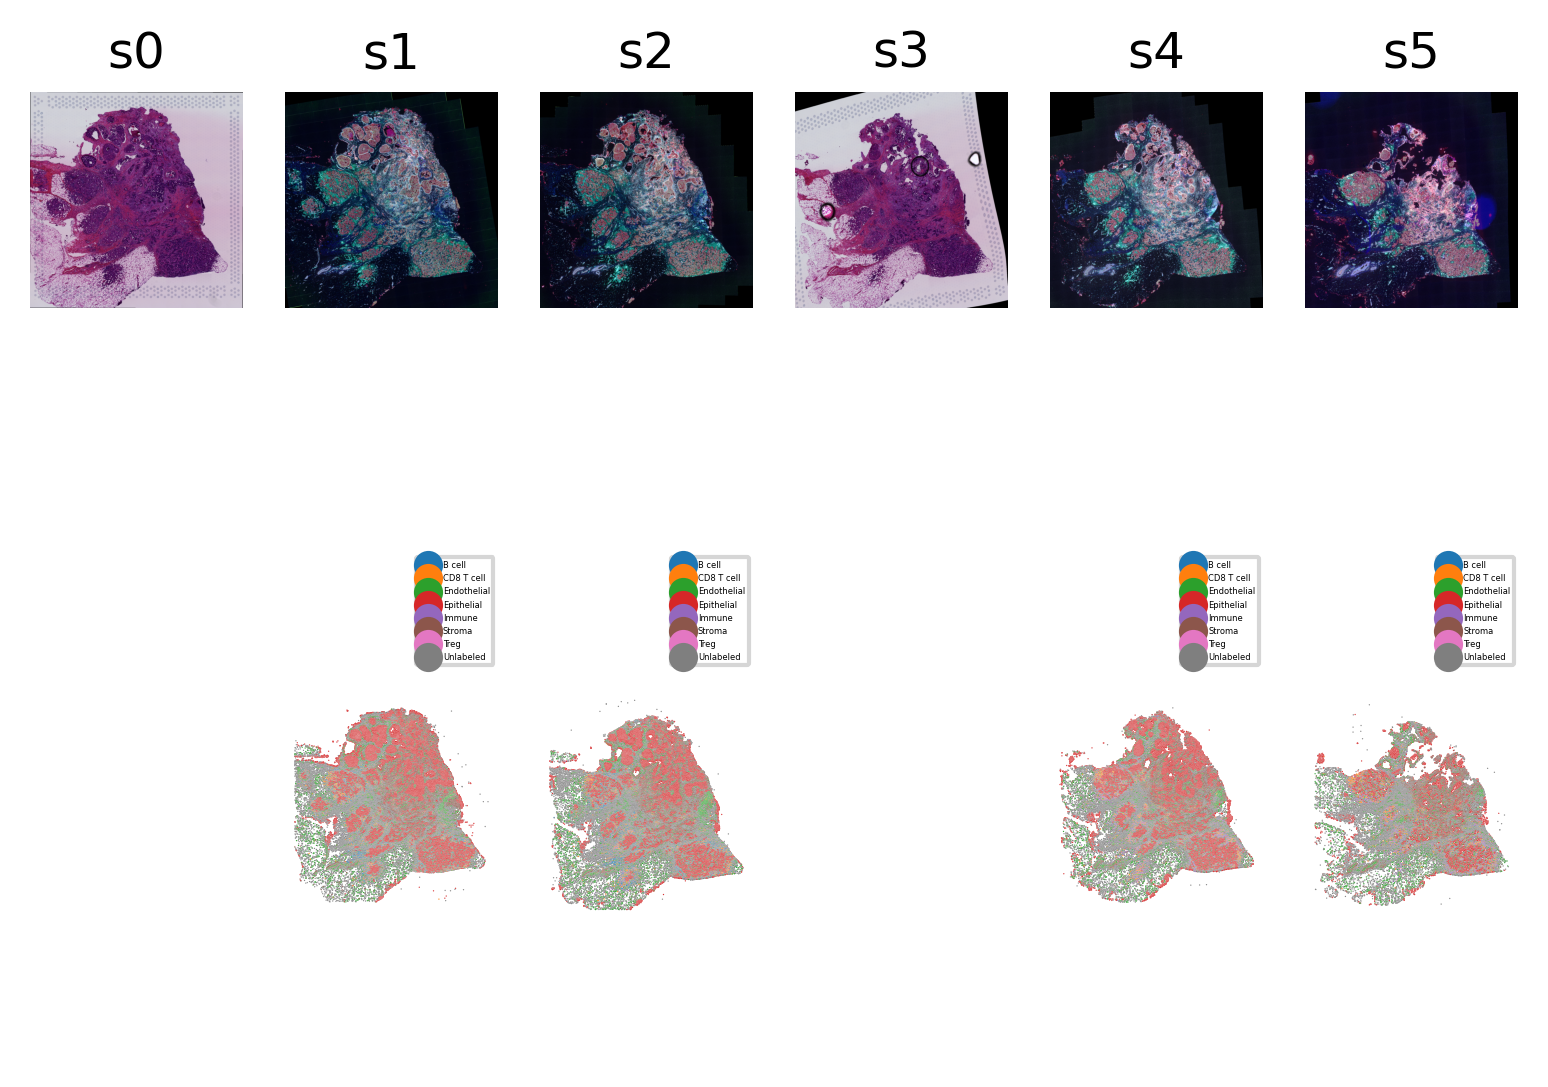

In [46]:
make_serial_figure(metadata, gene=None)
plt.savefig(os.path.join(out_dir, 'aligned.pdf'))

In [ ]:
make_serial_figure(metadata, gene='EPCAM', colorbar_loc='bottom')
plt.savefig(os.path.join(out_dir, 'aligned_epcam.pdf'))